In [1]:
# usage: Rscript run_limma.R counts.tsv design.tsv out_dir/basename Lum Basal
library("limma")
library("edgeR")
library("matrixStats")
library("RColorBrewer")

In [8]:
counts_file <- "5_clients.counts.tsv"
design_file  <- "5_clients.design.tsv"
outfile_basename  <- "5_clients"
group1 <- "Lum"
group2 <- "Basal"

#covars <- c(group1,group2,"diagnosis_age","stage")
#covars <- c(group1,group2,"diagnosis_age","stage","client_2","client_3") # "is_LumA"
covars <- c(group1,group2,"diagnosis_age","stage","client_2","client_3","client_4","client_5") # "is_LumA"

In [9]:
# read inputs
counts <- read.delim(counts_file, row.names = 1)
colnames(counts) <- gsub("\\.", "-",colnames(counts))

design_m <- read.delim(design_file, row.names = 1)
design_m <- design_m[,covars]
all_groups <- c(group1,group2)
print(head(design_m,3))

raw_exprs <- DGEList(counts)

                Lum Basal diagnosis_age stage client_2 client_3 client_4
TCGA-E2-A15F-01   1     0            64     1        0        0        0
TCGA-AO-A1KR-01   0     1            51     2        0        0        0
TCGA-D8-A1JM-01   0     1            59     2        0        0        0
                client_5
TCGA-E2-A15F-01        0
TCGA-AO-A1KR-01        0
TCGA-D8-A1JM-01        0


In [10]:
# filter and normalize
exprs <- raw_exprs 
group = as.factor(apply(design_m[all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(exprs, group=group)
cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
exprs <- calcNormFactors(exprs, method = "upperquartile") # TMM
lcpm <- cpm(exprs, log=TRUE)


Genes passed filterByExprs: 16833

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


null device 
          1

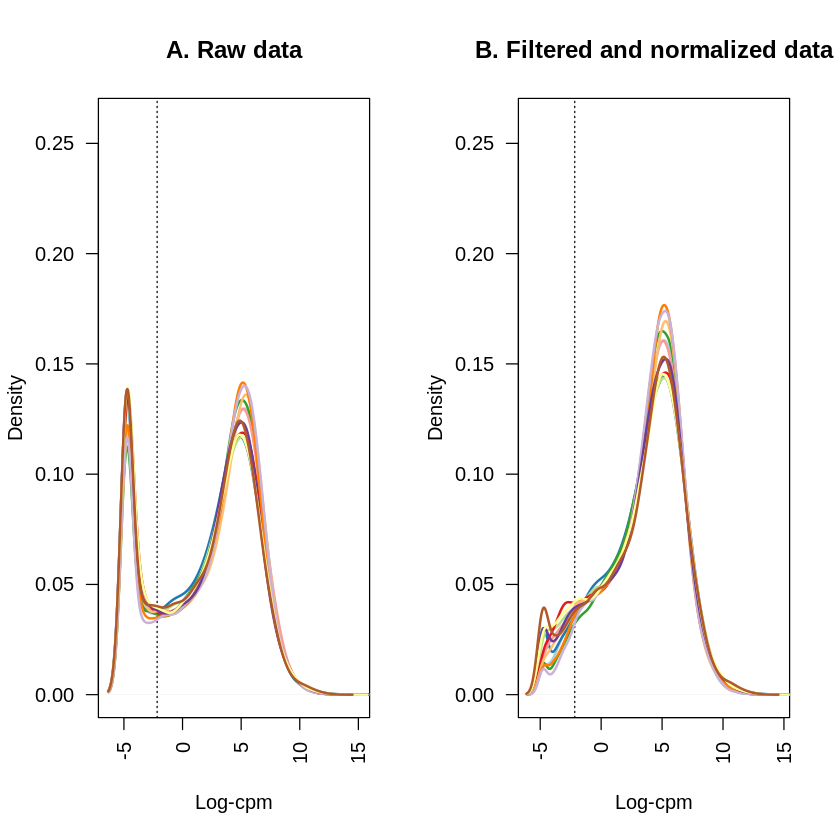

In [11]:
nsamples <- ncol(exprs)
col <- brewer.pal(nsamples, "Paired")
#samplenames <- substring(colnames(exprs), 12, nchar(colnames(exprs)))

par(mfrow=c(1,2))

# calculate mean and median lib.sizes for raw expressions
raw_lcpm <- cpm(raw_exprs, log=TRUE)
L <- mean(raw_exprs$samples$lib.size) * 1e-6
M <- median(raw_exprs$samples$lib.size) * 1e-6
lcpm_cutoff <- log2(10/M + 2/L)

plot(density(raw_lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm_cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(raw_lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
#legend("topright", samplenames, text.col=col, bty="n")


plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered and normalized data", xlab="Log-cpm")
abline(v=lcpm_cutoff, lty=3)

for (i in 2:nsamples){
den <- density(lcpm[,i])
lines(den$x, den$y, col=col[i], lwd=2)
}

dev.off()

null device 
          1

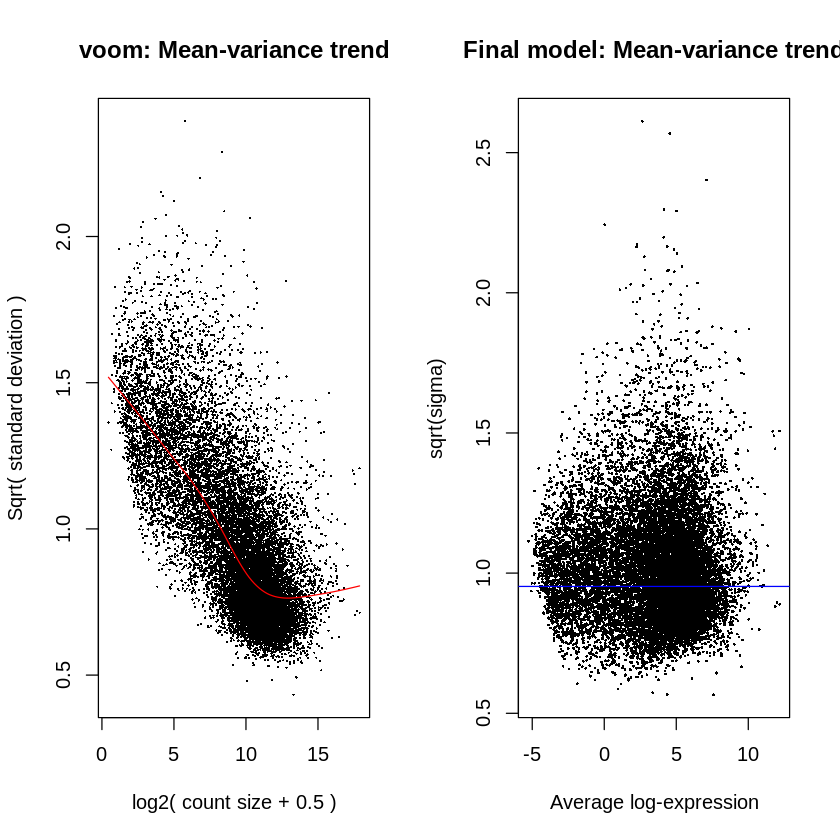

In [12]:
par(mfrow=c(1,2))
voom_results <-  voom(exprs, design_m, plot = T, save.plot=F)

### lmFit limma ### 
fit <- lmFit(voom_results, design_m)
contrasts_matrix <- makeContrasts(Lum - Basal, levels = colnames(fit$coefficients))
#contrasts_matrix <- makeContrasts(sun_exposed - not_sun_exposed, levels = colnames(fit$coefficients))

contr_fit <- contrasts.fit(fit, contrasts_matrix)
result <- eBayes(contr_fit)

### plot ###
plotSA(result, main="Final model: Mean-variance trend")
dev.off()


In [14]:
table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1]) # lfc=2 -logFC

write.table(table_res,paste0(outfile_basename,".Rlimma_voom.tsv"),row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
head(table_res)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXA1,6.714880,6.364706,7.065054,7.3650686,37.89244,2.814214e-78,4.737166e-74,167.39579
ESR1,6.882561,6.376152,7.388969,7.8219906,26.85636,6.667635e-59,5.611815e-55,123.61028
SPDEF,5.685872,5.233036,6.138707,6.4394968,24.81160,1.022563e-54,5.737603e-51,114.07374
MLPH,5.447009,4.999814,5.894204,7.3395878,24.06905,3.827262e-53,1.610607e-49,110.53390
XBP1,3.389709,3.100014,3.679403,10.5973349,23.12172,4.288499e-51,1.443766e-47,105.88324
CT62,6.136788,5.575567,6.698010,0.1828378,21.60752,1.019991e-47,2.861586e-44,96.71236


### Previous runs 
(do not re-run these tabs)

In [13]:
# 5 
table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1]) # lfc=2 -logFC

head(table_res)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXA1,6.714880,6.364706,7.065054,7.3650686,37.89244,2.814214e-78,4.737166e-74,167.39579
ESR1,6.882561,6.376152,7.388969,7.8219906,26.85636,6.667635e-59,5.611815e-55,123.61028
SPDEF,5.685872,5.233036,6.138707,6.4394968,24.81160,1.022563e-54,5.737603e-51,114.07374
MLPH,5.447009,4.999814,5.894204,7.3395878,24.06905,3.827262e-53,1.610607e-49,110.53390
XBP1,3.389709,3.100014,3.679403,10.5973349,23.12172,4.288499e-51,1.443766e-47,105.88324
CT62,6.136788,5.575567,6.698010,0.1828378,21.60752,1.019991e-47,2.861586e-44,96.71236


In [7]:
# 3 
table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1]) # lfc=2 -logFC
head(table_res)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXA1,6.692861,6.358088,7.027633,7.3650686,39.50148,2.222892e-81,3.741793e-77,174.3917
ESR1,6.874176,6.384937,7.363414,7.8219906,27.76203,4.096201e-61,3.447567e-57,128.6345
SPDEF,5.734792,5.299375,6.170209,6.4394968,26.02335,1.312107e-57,7.362231e-54,120.6596
MLPH,5.392014,4.969929,5.814099,7.3395878,25.24077,5.562606e-56,2.340884e-52,117.0206
XBP1,3.370644,3.088654,3.652634,10.5973349,23.61732,1.669376e-52,5.620121e-49,109.1031
CT62,6.207484,5.664973,6.749994,0.1828378,22.60780,2.855136e-50,8.010085e-47,102.3284


In [14]:
# 1
table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1]) # lfc=2 -logFC
head(table_res)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXA1,6.694251,6.359604,7.028898,7.3650686,39.52026,4.567224e-82,7.688008e-78,175.9228
ESR1,6.884172,6.395036,7.373307,7.8219906,27.80531,1.267850e-61,1.067086e-57,129.7806
SPDEF,5.738534,5.301683,6.175385,6.4394968,25.95211,7.617098e-58,4.273954e-54,121.1827
MLPH,5.410377,4.980650,5.840104,7.3395878,24.87367,1.447477e-55,6.091347e-52,116.0619
XBP1,3.370117,3.089564,3.650671,10.5973349,23.73200,4.358512e-53,1.467337e-49,110.4315
CT62,6.219342,5.674367,6.764316,0.1828378,22.54621,1.939439e-50,5.441096e-47,102.6629
